In [2]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial) #cw.targets.SimpleSerial can be omitted
scope.default_setup()

print(scope)


See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


Serial baud rate = 38400
ChipWhisperer Nano Device
fw_version = 
    major = 0
    minor = 24
    debug = 0
io = 
    tio1         = None
    tio2         = None
    tio3         = None
    tio4         = None
    pdid         = True
    pdic         = False
    nrst         = True
    clkout       = 7500000.0
    cdc_settings = None
adc = 
    clk_src  = int
    clk_freq = 7500000.0
    samples  = 5000
glitch = 
    repeat     = 0
    ext_offset = 0



In [3]:
%%bash
cd ../../hardware/victims/firmware/lab-04/
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- lab-04-CWNANO.hex
rm -f -- lab-04-CWNANO.eep
rm -f -- lab-04-CWNANO.cof
rm -f -- lab-04-CWNANO.elf
rm -f -- lab-04-CWNANO.map
rm -f -- lab-04-CWNANO.sym
rm -f -- lab-04-CWNANO.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- tvla-test.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s
rm -f -- tvla-test.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d
rm -f -- tvla-test.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lowlevel.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: tvla-test.c
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -mthumb -mfloat-abi=soft -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F030x6 -DSTM32F0 -DSTM32 -DDEBUG -DHAL_TYPE

In [4]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../../hardware/victims/firmware/demo/demo-CWNANO.hex")

Serial baud rate = 115200
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4915 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4915 bytes
Serial baud rate = 38400


In [131]:
msg1 = bytearray([0]*16)
msg2 = bytearray([15]*16)

print(msg1)
print(msg2)

target.simpleserial_write('a', msg1)
print(target.simpleserial_read('r', 16))
target.simpleserial_write('a', msg2)
print(target.simpleserial_read('r', 16))

CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00')
CWbytearray(b'0f 0f 0f 0f 0f 0f 0f 0f 0f 0f 0f 0f 0f 0f 0f 0f')
CWbytearray(b'00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00')
CWbytearray(b'f0 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00')


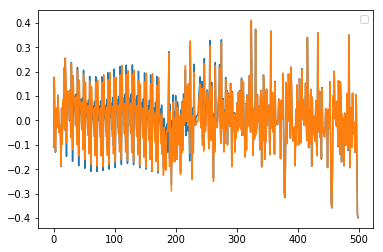

In [132]:
trace_A = []
trace_B = []

scope.adc.samples = 500

for i in range(32):
    scope.arm()
    target.simpleserial_write('b', msg1)
    scope.capture()
    trace_A.append(scope.get_last_trace())
    
for i in range(32):
    scope.arm()
    target.simpleserial_write('b', msg2)
    scope.capture()
    trace_B.append(scope.get_last_trace())
    
trace_A = np.array(trace_A)
trace_B = np.array(trace_B)

legend = ['msg1, msg2']

plt.legend(legend, [trace_A, trace_B])
plt.plot(np.average(trace_A, axis=0))
plt.plot(np.average(trace_B, axis=0))

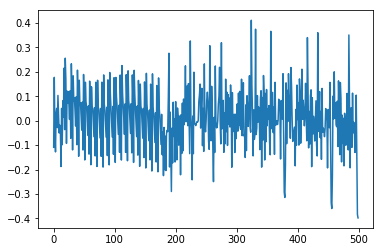

In [134]:

plt.plot(np.average(trace_B, axis=0))

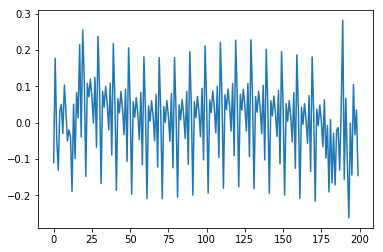

In [135]:

plt.plot(np.average(trace_A, axis=0)[0:200])

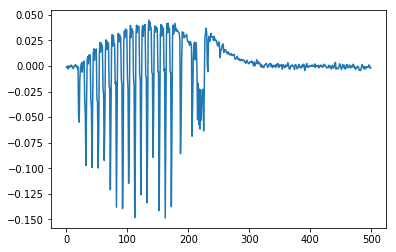

In [136]:
#diff_trace = trace_A[0,0:200] - trace_B[0,0:200]
diff_trace = np.average(trace_A, axis=0) - np.average(trace_B, axis=0)

plt.plot(diff_trace)

In [114]:
print("A-1 mean: ", trace_A[0,:].mean(), "+/-", trace_A[0,:].std())
print("A-2 mean: ", trace_B[0,:].mean(), "+/-", trace_B[0,:].std())
print("Differential trace mean: ", trace_B[0,:].mean(), "+/-", trace_B[0,:].std())

A-1 mean:  0.00928125 +/- 0.12538457831993832
A-2 mean:  0.0095546875 +/- 0.12658559082375537
Differential trace mean:  0.0095546875 +/- 0.12658559082375537


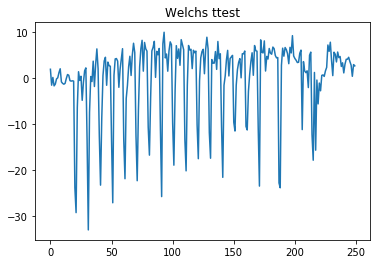

In [121]:
t, p = scipy.stats.ttest_ind(trace_A[0:250], trace_B[0:250], equal_var=False)
plt.title('Welchs ttest')
plt.plot(t[0:250])

In [122]:
temp = 0
for pval in p:
    if pval <= 0.05:
        temp += 1
print(len(p))
print(temp/len(p))

500
0.454
